In [1]:
import jupyter_black

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from PIL import Image

import sys

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src/")

jupyter_black.load()

In [2]:
# Custom modules
from dataset import create_substrate_dataset, get_part_substrates_from_all
from unet import UNet
from diffusion import Diffusion

In [3]:
# Dirs
substrate_dir = "/usr/src/substrates/"
part_substrate_dir = "/usr/src/part_substrates/"

In [4]:
# If little substrates are not exist !
# get_part_substrates_from_all(substrate_dir, part_substrate_dir)

In [5]:
substrate_dataset = create_substrate_dataset(part_substrate_dir)

image_size = 128
channels = 1
batch_size = 125

train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torchvision.transforms as transforms

with Image.open(part_substrate_dir + "part_substrate_1000.png") as img:
    img.show()
    plt.imshow(transforms.ToTensor()(img).permute(1, 2, 0))

In [ ]:
plt.imshow(substrate_dataset[1000].permute(1, 2, 0))
# plt.imsave("1000.png", substrate_dataset[1000], cmap="gray")

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(img_dim=image_size, img_channels=channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
timesteps = 400
diffusion = Diffusion(timesteps, beta_schedule="linear")

In [14]:
epochs = 6
for epoch in range(epochs):
    print(f"----- Epoch {epoch + 1} -----")
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = diffusion.p_losses(model, batch, t, loss_type="huber")

        if step % 14 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

----- Epoch 1 -----
Loss: 0.5800383687019348
Loss: 0.03789461776614189
Loss: 0.020989706739783287
Loss: 0.018111541867256165
----- Epoch 2 -----
Loss: 0.008904874324798584
Loss: 0.008562872186303139
Loss: 0.007735961116850376
Loss: 0.01073406357318163
----- Epoch 3 -----
Loss: 0.006203809753060341
Loss: 0.004060475621372461
Loss: 0.012732741422951221
Loss: 0.009100217372179031
----- Epoch 4 -----
Loss: 0.004775358363986015
Loss: 0.01393058616667986
Loss: 0.003914498724043369
Loss: 0.005947650410234928
----- Epoch 5 -----
Loss: 0.008123126812279224
Loss: 0.007643780205398798
Loss: 0.009104480035603046
Loss: 0.0056843520142138
----- Epoch 6 -----
Loss: 0.004403344355523586
Loss: 0.005072422791272402
Loss: 0.00599219836294651
Loss: 0.007196490187197924


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

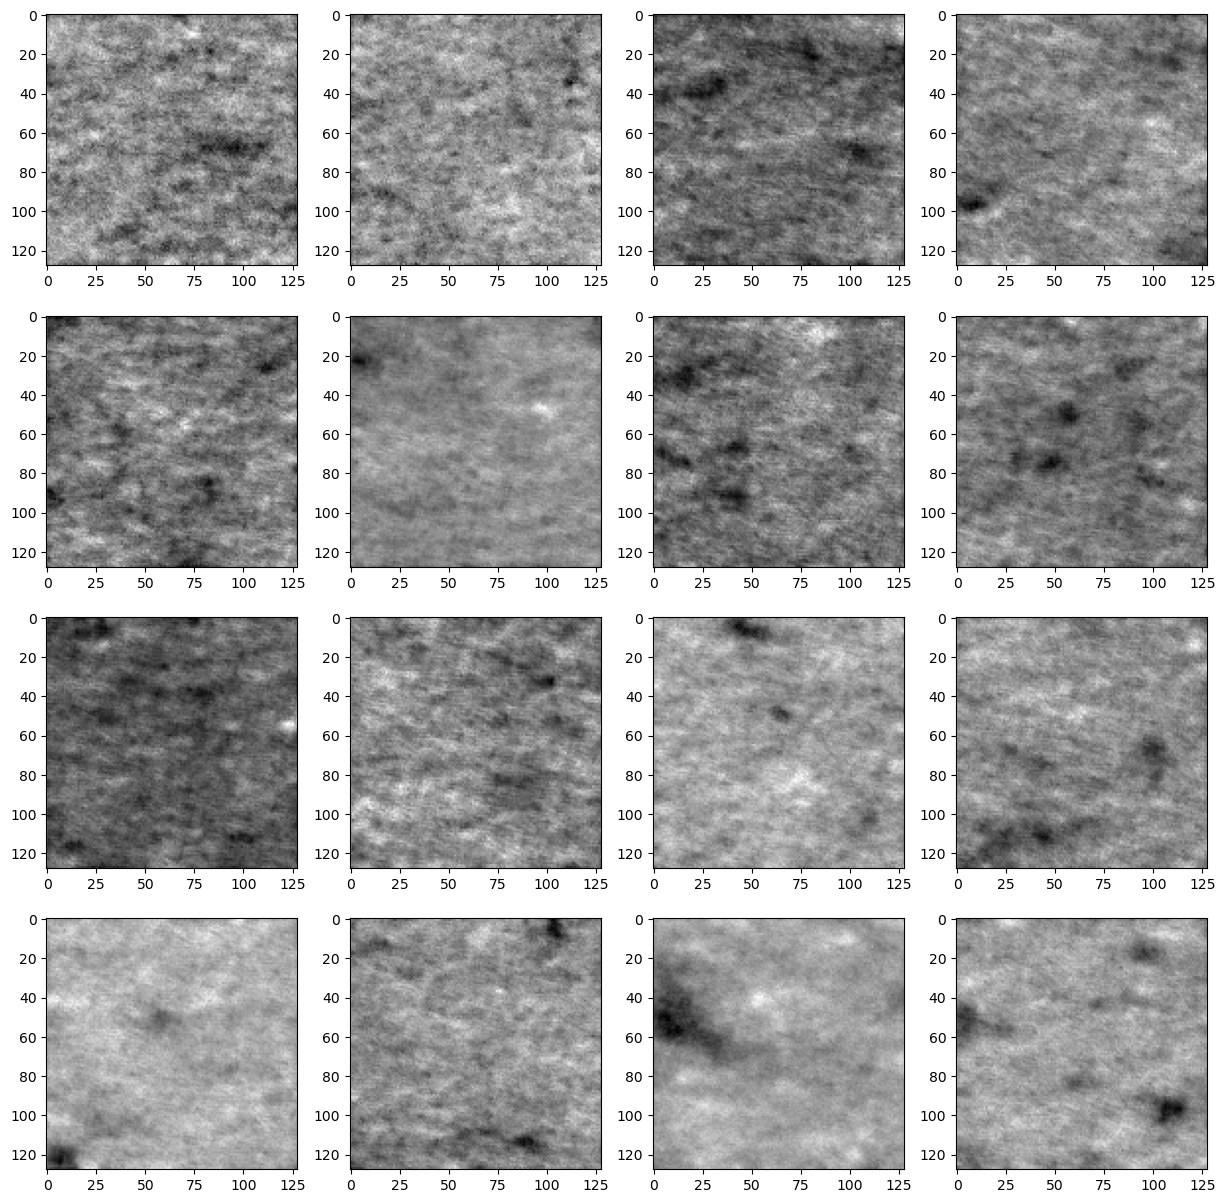

In [15]:
# sample 16 images
samples = diffusion.sample(model, image_size=image_size, channels=channels)
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for ax, img in zip(axes.flat, samples[-1]):
    ax.imshow(img.reshape(image_size, image_size, channels), cmap="gray")

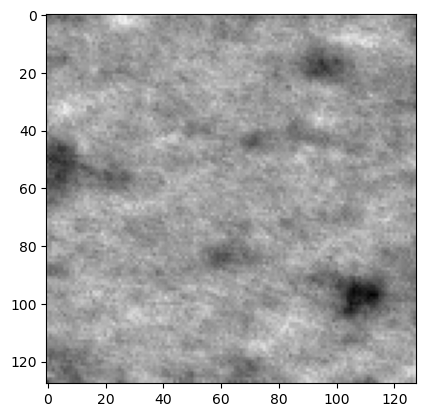

In [16]:
# show a random one
random_index = 15

plt.imshow(
    samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray"
)

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(
        samples[i][random_index].reshape(image_size, image_size, channels),
        cmap="gray",
        animated=True,
    )
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save("diffusion.gif")
plt.show()